# 设定：
使用class[cls]的三天数据，预测class[cls]的七天数据

In [13]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipdb
import os

import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import backend as K
import tensorflow.keras as keras
from tensorflow.keras.layers import Layer
import dan_models
import dan_utils
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings("ignore")

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.compat.v1.enable_eager_execution()
tf.executing_eagerly()

True

# Load data

In [15]:
class_set = [2, 3, 4]
randseed = 25
res = 11
v, v_class, id_402, part1, part2, seg, det_list_class, near_road_set  \
        = dan_utils.load_data(class_set, res, randseed)
class_color_set = ['b', 'g', 'y', 'black', 'r']

# ind, class
# 0  , blue
# 1  , green
# 2  , yellow  <--
# 3  , black   <--
# 4  , red     <--
class_src = 3
v_class1 = v_class[class_src]  # source
near_road1 = np.array(near_road_set[class_src])

class_tar = 2
v_class2 = v_class[class_tar]  # target
near_road2 = np.array(near_road_set[class_tar])

num_links = v_class1.shape[0]

near_road_src = near_road1
flow_src = v_class1.iloc[:, 2:-1]
prop = 1  # proportion of training data
from_day = 1
to_day = 24

image_train_source, image_test_source, day_train_source, day_test_source, label_train_source, label_test_source\
= dan_utils.sliding_window(
    flow_src, near_road_src, from_day, to_day, prop, num_links
)

near_road_tar = near_road2
flow_tar = v_class2.iloc[:, 2:-1]
prop = 3/10
from_day = 22
to_day = 31

image_train_target, image_test_target, day_train_target, day_test_target, label_train_target, label_test_target\
= dan_utils.sliding_window(
    flow_tar, near_road_tar, from_day, to_day, prop, num_links
)

dup_mul = image_train_source.shape[0]//image_train_target.shape[0]
dup_r   = image_train_source.shape[0]%image_train_target.shape[0]

image_train_target, day_train_target, label_train_target = \
np.concatenate((np.tile(image_train_target, [dup_mul, 1, 1, 1]), image_train_target[:dup_r, :, :, :]), axis=0),\
np.concatenate((np.tile(day_train_target, [dup_mul, 1, 1]), day_train_target[:dup_r, :, :]), axis=0),\
np.concatenate((np.tile(label_train_target, [dup_mul, 1, 1]), label_train_target[:dup_r, :, :]), axis=0),

t_input = image_train_source.shape[2]
t_pre = label_train_source.shape[2]
k = image_train_source.shape[1]

There are 5 class(es)
(2772, 5, 12, 40)
(2772, 5, 12, 40)
(0, 5, 12, 40)
(2772, 40, 6)
(0, 40, 6)
(1008, 5, 12, 40)
(302, 5, 12, 40)
(706, 5, 12, 40)
(302, 40, 6)
(706, 40, 6)


# 用前三天的数据取平均，得到之后数据的预测值

In [18]:

data = v_class2.iloc[:, 2:-1]
v_his1 = np.array(data.iloc[:, 4466-144*10-1:4466-144*9-1])
v_his2 = np.array(data.iloc[:, 4466-144*9-1:4466-144*8-1])
v_his3 = np.array(data.iloc[:, 4466-144*8-1:4466-144*7-1])

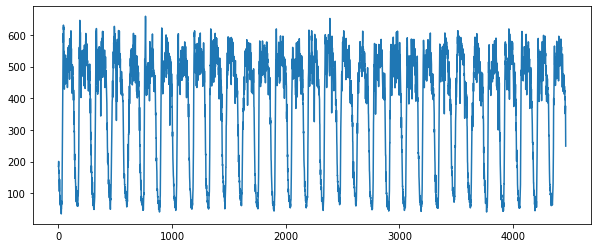

In [19]:
plt.figure(figsize=[10,4])
plt.plot(np.array(data.iloc[5, :]) )

In [20]:
v_pre = (v_his1+v_his2+v_his3)/3
print(v_pre.shape)

(40, 144)


In [21]:
v_pre = np.concatenate((v_pre, v_pre, v_pre, v_pre, v_pre, v_pre), axis=1)
v_pre.shape

(40, 864)

In [22]:
label = np.array(v_class[0].iloc[:, 4466-144*7-1:4466-144-1])
print(label.shape)

(40, 864)


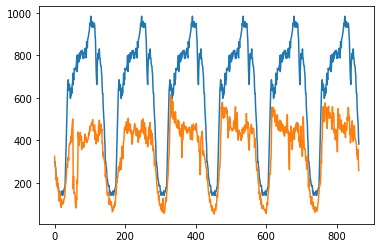

In [23]:
plt.plot(v_pre[0, :])
plt.plot(label[0, :])

In [24]:
print(dan_utils.mape_loss_func(v_pre, label, 5))
print(dan_utils.smape_loss_func(v_pre, label, 5))
print(dan_utils.nrmse_loss_func(v_pre, label, 5))
print(dan_utils.mae_loss_func(v_pre, label, 5))

1.9672446794723182
0.6349006659117983
0.2628838643577793
214.42226134803408
